# 0. Configurations

In [1]:
import  numpy               as      np
import  matplotlib.pyplot   as      plt


np.random.seed(486)
np.printoptions(precision = 4)

## Remark (Conditional distribution in multivariate normal distribution)


Let $A$ and $B$ be random vectors of dimension $m$ and $n$, respectively, and assume that the joing distribution of $A$ and $B$ is given by the normal distribution
\begin{align*}
\begin{pmatrix}
A\\B
\end{pmatrix}
\sim
\mathcal{N}
\begin{pmatrix}
    \begin{pmatrix}
        \mu_A
        \\
        \mu_B
    \end{pmatrix},
    \begin{pmatrix}
        \Sigma      &   \Sigma_* \\
        \Sigma_*^T  &   \Sigma_{**}
    \end{pmatrix}
\end{pmatrix}.
\end{align*}
Then the conditional distribution of $B$ given $A$ is given by
\begin{align*}
B | A
\sim
\mathcal{N}
\begin{pmatrix}
    \mu_{B | A}, \Sigma_{B | A}
\end{pmatrix},
\end{align*}
where $\mu_{B | A} = \mu_B + K_*^T K^{-1} (A - \mu_A)$ and $\Sigma_{B | A} = K_{**} - K_*^T K^{-1} K_*$.

# Remark (Computational remark)

When computing the conditional expectation $\mu_{B | A} = \mu_B + K_*^T K^{-1} (A - \mu_A)$, using the Cholesky decomposition $K = LL^T$ of $K$ with a lower triangular matrix $L$, we find that
\begin{align*}
    \mu_{B | A}
    =
    \mu_B
    +
    (
        \color{brown}
        L^{-1} K_*
        \color{black}
    )^T
    (
        \color{orange}
        L^{-1} (A - \mu_A)
        \color{black}
    ),
\end{align*}
so one can use the function `{numpy, torch, ...}.linalg.solve` to compute each colored matrix.
Similarly, when computing the conditional covariance matrix $\Sigma_{B | A} = K_{**} - K_*^T K^{-1} K_*$ with the Cholesky decomposition $K = LL^T$ (again, $L$ is lower triangular), we have
\begin{align*}
    \Sigma_{B | A}
    =
    K_{**}
    -
    (
        \color{brown}
        L^{-1} K_*
        \color{black}
    )^T
    (
        \color{brown}
        L^{-1}K_*
        \color{black}
    ),
\end{align*}
which gives a similar way of an efficient computation.

# 1. Gaussian process regression



We assume that the observations contain iid. noise $\epsilon_n \sim \mathcal(0, \sigma^2)$ with $\sigma = 10^{-2}$ and $n \in \mathbb{N}$.
The dataset is generated as $\{
    (x_i, y_i)\}_{i = 1}^{N}$ with $N = 5$, $y_i = \cos(x_i) + \epsilon_i$.
Also, we assume that $\mu = 0$.

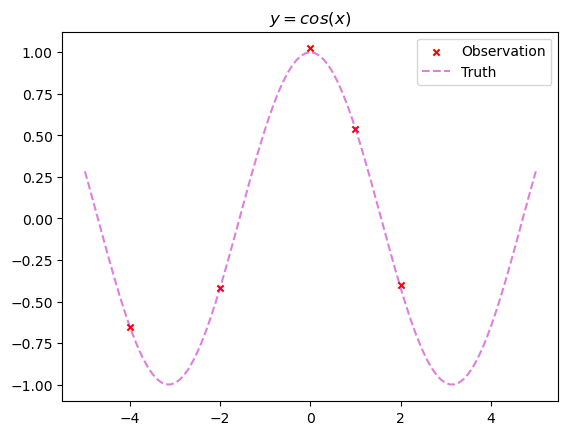

In [2]:
sigma = 1e-2

def target_fcn(x: float | np.ndarray) -> float | np.ndarray:
    return np.cos(x)

def kernel(vec1: np.ndarray, vec2: np.ndarray, l: float = 1.0) -> np.ndarray:
    assert vec1.shape[-1] == vec2.shape[-1], \
        f"Shape mismatch (vec1.shape: {vec1.shape}, vec2.shape: {vec2.shape})"
    
    return np.exp(-(vec1 - vec2.T)**2 / (2 * l**2))


__x = np.linspace(-5, 5, 101).reshape(-1, 1)

x = np.array([-4., -2., 0., +1., +2.]).reshape(-1, 1)
y = target_fcn(x) + np.random.normal(loc = 0, scale = sigma, size = x.shape)

plt.title("$y = cos(x)$")
plt.scatter(x, y, s = 20, marker = 'x', color = 'r', label = "Observation")
fig = plt.plot(__x, target_fcn(__x), 'm--', alpha = 0.5, label = "Truth")
plt.legend()

plt.show()

In [3]:
x_post = np.linspace(-5, 5, 50).reshape(-1, 1)

In [4]:
# Compute all statistics

mu_A = np.zeros(shape = x.shape)
mu_B = np.zeros(shape = x_post.shape)

cov = kernel(x, x)
cov_star = kernel(x, x_post)
cov_star_star = kernel(x_post, x_post)

cov_with_error = cov + (sigma**2) * np.eye(*cov.shape)
L = np.linalg.cholesky(cov_with_error)  # L @ L.T == cov_with_error
L_inv__cov_star = np.linalg.solve(L, cov_star)

print(cov.shape, cov_star.shape, cov_star_star.shape)
print(L_inv__cov_star.shape)

(5, 5) (5, 50) (50, 50)
(5, 50)


In [5]:
mu_post  = mu_B + L_inv__cov_star.T @ np.linalg.solve(L, y - mu_A)
cov_post = cov_star_star - L_inv__cov_star.T @ L_inv__cov_star

print(f"mu_post.shape:  {mu_post.shape}")
print(f"cov_post.shape: {cov_post.shape}")

mu_post.shape:  (50, 1)
cov_post.shape: (50, 50)


In [6]:
y_post = np.random.multivariate_normal(mean = mu_post.reshape(-1), cov = cov_post, size = 1).T
print(y_post.shape)

(50, 1)


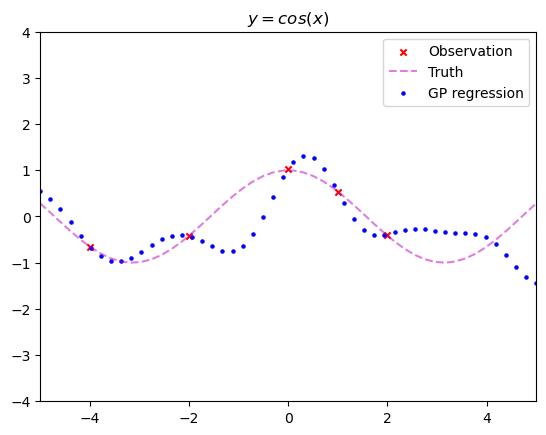

In [7]:
plt.title("$y = cos(x)$")
plt.scatter(x, y, s = 20, marker = 'x', color = 'r', label = "Observation")
fig = plt.plot(x_post, target_fcn(x_post), 'm--', alpha = 0.5, label = "Truth")
plt.scatter(x_post, y_post, s = 20, c = 'b', marker = '.', label = "GP regression")
plt.legend()
plt.axis((-5, 5, -4, 4))
plt.show()

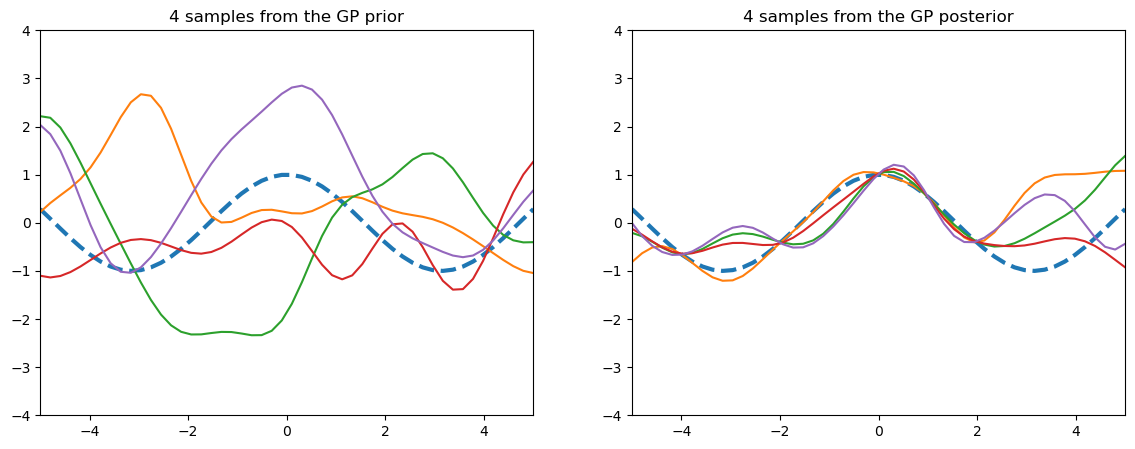

In [8]:
num_trials = 4


fig, axes = plt.subplots(1, 2, figsize = (14, 5))

for cnt, is_prior in enumerate([True, False]):
    axes[cnt].set_title(f"{num_trials} samples from the GP {'prior' if is_prior else 'posterior'}")
    axes[cnt].plot(x_post, target_fcn(x_post), '--', linewidth = 3)
    for _ in range(num_trials):
        if is_prior:
            _y_post = np.random.multivariate_normal(mean = np.zeros(shape = (x_post.size)), cov = cov_star_star).reshape(-1)
        else:
            _y_post = np.random.multivariate_normal(mean = mu_post.flatten(), cov = cov_post).reshape(-1)
        axes[cnt].plot(x_post, _y_post)
    axes[cnt].axis((-5, 5, -4, 4))
plt.show()